In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device) My laptop uses cpu

#Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

loaders = {
    'train' :   torch.utils.data.DataLoader(train_data,
                                            batch_size = 100,
                                            shuffle=True
                                           ),
    'test'  :   torch.utils.data.DataLoader(test_data,
                                            batch_size = 100,
                                            shuffle=True
                                            )
}

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x   # return x for visualization
cnn = CNN()

In [8]:
print(CNN().parameters())

<generator object Module.parameters at 0x13dc7ff20>


In [4]:

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=20,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(20, 40, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(40 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x   # return x for visualization

cnn1 = CNN1()

In [5]:
from torch.autograd import Variable

def train(num_epochs, model, loaders, optimizer):
    LA = []
    model.train()
    loss_func = nn.CrossEntropyLoss()  
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        Train_loss = 0
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)
            b_y = Variable(labels)
            # or use data, target = Variable(images), Variable(labels)
            output = model(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()

            #apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print( 'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
            Train_loss += loss.item() 
        Train_loss /= len(loaders['train'])
        acc = test(model)
        LA.append([epoch+1, Train_loss, acc])
    return LA

In [6]:
def test(model):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    test_loss = 0
    n_correct = 0
    n_samples = 0
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output, last_layer = model(images)
            test_loss += loss_fn(test_output, labels).data
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            n_samples += labels.size(0)
            n_correct += (pred_y == labels).sum().item()
            accuracy= 100.0 * n_correct / n_samples
#            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    test_loss /= len(loaders['test'])
    print(accuracy)
#    print(len(loaders['test']))
#            print('Test Accuracy of the model on the 10000 test image: %.2f' % accuracy)
#    print(accuracy, (pred_y == labels).sum().item(), float(labels.size(0)))
    return accuracy

In [7]:
num_epochs = 10

optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)
loss_acc = train(num_epochs, cnn, loaders, optimizer)
L = np.array(loss_acc)

optimizer = torch.optim.Adam(cnn1.parameters(), lr = 0.01)
loss_acc1 = train(num_epochs, cnn1, loaders, optimizer)
L1 = np.array(loss_acc1)

Epoch [1/10], Step [100/600], Loss: 0.0898
Epoch [1/10], Step [200/600], Loss: 0.0974
Epoch [1/10], Step [300/600], Loss: 0.1986
Epoch [1/10], Step [400/600], Loss: 0.0196
Epoch [1/10], Step [500/600], Loss: 0.0719
Epoch [1/10], Step [600/600], Loss: 0.0175
98.38
Epoch [2/10], Step [100/600], Loss: 0.0393
Epoch [2/10], Step [200/600], Loss: 0.0093
Epoch [2/10], Step [300/600], Loss: 0.0624
Epoch [2/10], Step [400/600], Loss: 0.0158
Epoch [2/10], Step [500/600], Loss: 0.0177
Epoch [2/10], Step [600/600], Loss: 0.0320
98.63
Epoch [3/10], Step [100/600], Loss: 0.1246
Epoch [3/10], Step [200/600], Loss: 0.0770
Epoch [3/10], Step [300/600], Loss: 0.0074
Epoch [3/10], Step [400/600], Loss: 0.0190
Epoch [3/10], Step [500/600], Loss: 0.0615
Epoch [3/10], Step [600/600], Loss: 0.0147
98.63
Epoch [4/10], Step [100/600], Loss: 0.0185
Epoch [4/10], Step [200/600], Loss: 0.0060
Epoch [4/10], Step [300/600], Loss: 0.0444
Epoch [4/10], Step [400/600], Loss: 0.0543
Epoch [4/10], Step [500/600], Loss: 

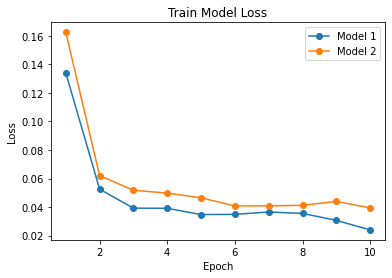

In [10]:
#plot the loss data
plt.plot(L[:,0], L[:,1], marker = 'o', label = 'Model 1')
plt.plot(L1[:,0], L1[:,1], marker = 'o', label = 'Model 2')
plt.title('Train Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

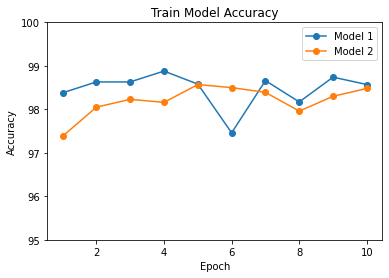

In [12]:
plt.plot(L[:,0], L[:,2], marker = 'o', label = 'Model 1')
plt.plot(L1[:,0], L1[:,2], marker = 'o', label = 'Model 2')
plt.title('Train Model Accuracy')
plt.ylim(95, 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()